<bold><font size="6">Transfer Learning Tremor Location (TL): Tutorial</font></bold>
# Introduction

In this jupyter notebook we show how to use the `tl` package. This is how you import it:

In [ ]:
import tl

Our study case is the tremor from the Kilauea summit caldera collapse in 2018. For the sake of technical illustration, we use a minimal working example. The results are not satisfying since the training and prediction data sets are very small. Nonetheless, this example can be modified to run with the full dataset and reproduce the results presented in van der Laat et al. (2023).

## yaml configuration file

This file contains all the user-defined parameters that you can modify. We will modify and explain it along the way.

## Command-line programs

For every main step in this analysis we use command-line programs. If you were in your console and the installation of this package was succesful, you would be able to run it using a command like the following:

    $ tl-[PROGRAM] config.yml

Since we are in a jupyter notebook we will be appending a `!` in front of command lines or using the command

    %run ../bin/tl-[PROGRAM] config.yml

For each program a different set of parameters in the configuration file is used. To know which parameters are being used in a particular program run this command line:

    $ tl-help [PROGRAM]
    
For example:

In [ ]:
!tl-help feature_extraction_tremor

The options for `tl-help` can be printed by using this command:

In [ ]:
!tl-help -h

# Cartesian projection

The tl package works with cartesian coordinates. [Find out your EPSG code](https://epsg.io/). For this example, we use the [NAD83 / Hawaii zone 1](https://epsg.io/26961) projection with the code `26961`. In the configuration file

```yaml
projection:
    epsg: 26961
```

# Seismic stations
## `STATIONXML` response file

Let's first obtain our inventory from the IRIS-DMC and write it to a file for later use:

In [ ]:
from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime

client = Client('IRIS')

inventory = client.get_stations(
    starttime=UTCDateTime(2018, 1, 1),
    endtime=UTCDateTime(2019, 1, 1),
    network='HV',
    channel='EH*,HH*',
    minlatitude=19.3270,
    maxlatitude=19.4704,
    minlongitude=-155.3339,
    maxlongitude=-155.1631,
    level='channel'
)

inventory.write('inventory.xml', format='STATIONXML')

Annotate the path to this file in your configuration file:

```yaml
preprocess:
    inventory: inventory.xml
```

## Stations `CSV` file
For user easy network configuration we convert the STATIONXML file to a simple dataframe:

In [ ]:
df = tl.inventory.to_dataframe(inventory)

In this case we won't use stations `NAHU` and `NPT`:

In [ ]:
df = df[~df.station.isin(['NAHU', 'NPT'])]

We also perform the transformation of the coordinate system:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

df['x'], df['y'] = tl.projection.geographic_to_cartesian(
    df.longitude.values, df.latitude.values, 26961
)
df.reset_index(inplace=True)
df

Let's write the dataframe to a `csv` file:

In [ ]:
df.to_csv('channels.csv', index=False)

Annotate the path to this file in your configuration file:

```yaml
features:
    channels_csv: channels.csv
```

# Earthquake catalog

This package uses a catalog formatted as a `csv` file as following:

| time | latitude | longitude | depth | magnitude | eventid | x | y | z |
| ---- | -------- | --------- | ----- | --------- | ------- | - | - | - |
| 2018-04-29 01:24:11.320 | 19.40776 | -155.29421 | 1.265 | 0.64 | 42905052 | 521613 | 63595 | -1265 |

In this case we used the catalog genereted by [Shelly and Thelen (2019)](https://doi.org/10.1029/2019GL085636). We already downloaded and converted this catalog to the `catalog.csv` file in this directory. In this catalog the reference for the depth is the summit elevation (~1.2 km). We corrected to obtain a sea level reference.

Annotate the path to this file in your configuration file:

```yaml
dataset:
    catalog: catalog.csv
    magnitude_min: 1
    magnitude_max: 5
    n_events: 200
```
In this section of the configuration file you can control how the filter the catalog. In this example we use a small number of events.

# Synthetic tests
We run a synthetic test in order to have an idea of how well this dataset in combination with the network configuration can do for our purposes.

In [ ]:
%run ../bin/tl-synth config.yml

# Download earthquake waveforms

We download one file per event in parallel, so in the configuration file you can limit the number of threads (4 is recommended, higher numbers of threads results in poor returns).

```yaml
performance:
    max_workers: 4
```

Run the program:

In [ ]:
%run ../bin/tl-get_wfs_eq config.yml

You can scan the data you just download to count the number of events and stations/channel per event. The output can be used to clean the data afterwards.

In [ ]:
%run ../bin/tl-scan -i WFS_EQ/ -o .

This programs outputs a folder `WFS_SCAN` and the the plot above which shows the number of channels per event. For this example we will consider 49 channels minimum and maximum number of channels. We will clean the data using this cuttoff, we will move the incomplete to another folder `WFS_EQ_IC`:

In [ ]:
%run ../bin/tl-clean -i WFS_EQ -o . -f WFS_SCAN/count_channels_per_event.csv -n 49

# Feature extraction of earthquakes data

In the configuration file, under the section preprocess you can find the parameters used for pre-processing. Under the section `features` you'll find the parameter that determines the frequency `bands` in which to filter the signal and the `order` of the bandpass filter. The parameter `features.datatype` controls which type of data we are extracting, `eq` (earthquake) in this case. The folder where the waveforms are read from is under `dataset.wfs_dir`.

2022-08-29 10:40:44,903 - root - INFO - Processing...
2022-08-29 10:40:44,903 - root - INFO - Processing...


2022-08-29 10:40:47,670	INFO worker.py:1518 -- Started a local Ray instance.


2022-08-29 10:41:13,282 - root - INFO - Writing output...
2022-08-29 10:41:13,282 - root - INFO - Writing output...
2022-08-29 10:41:15,211 - root - INFO - Done.
2022-08-29 10:41:15,211 - root - INFO - Done.


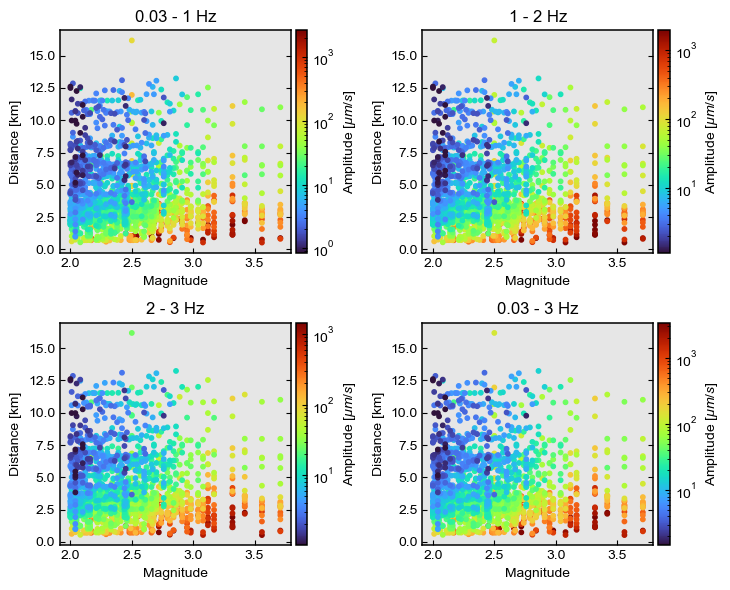

In [1]:
%run ../bin/tl-feature_extraction config.yml

# Training

2022-08-29 11:26:52,585 - root - INFO - Loading data...
2022-08-29 11:26:52,585 - root - INFO - Loading data...
2022-08-29 11:26:52,585 - root - INFO - Loading data...
2022-08-29 11:26:52,597 - root - INFO - Feature engeneering...
2022-08-29 11:26:52,597 - root - INFO - Feature engeneering...
2022-08-29 11:26:52,597 - root - INFO - Feature engeneering...
2022-08-29 11:27:57,687 - root - INFO - 4704 features computed.
2022-08-29 11:27:57,687 - root - INFO - 4704 features computed.
2022-08-29 11:27:57,687 - root - INFO - 4704 features computed.
2022-08-29 11:27:57,760 - root - INFO - Training with -29.0% of the dataset
2022-08-29 11:27:57,760 - root - INFO - Training with -29.0% of the dataset
2022-08-29 11:27:57,760 - root - INFO - Training with -29.0% of the dataset
2022-08-29 11:27:57,764 - root - INFO - n=68, n(train)=47, n(test)=21
2022-08-29 11:27:57,764 - root - INFO - n=68, n(train)=47, n(test)=21
2022-08-29 11:27:57,764 - root - INFO - n=68, n(train)=47, n(test)=21
2022-08-29 11

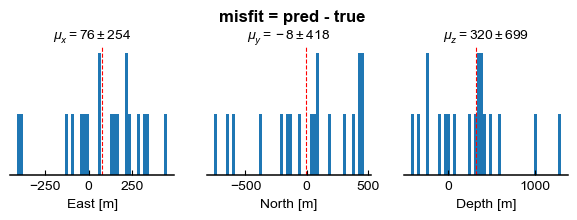

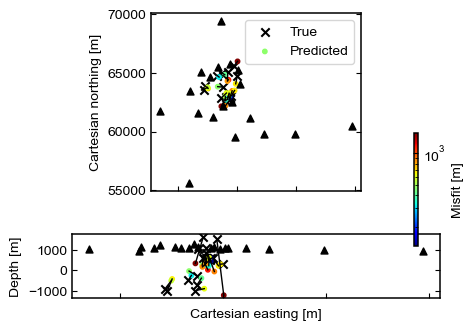

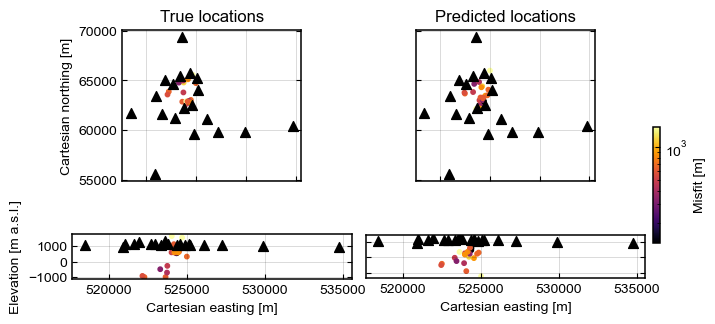

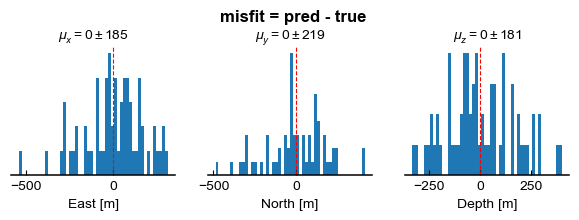

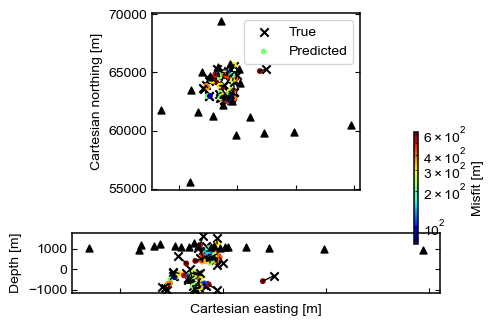

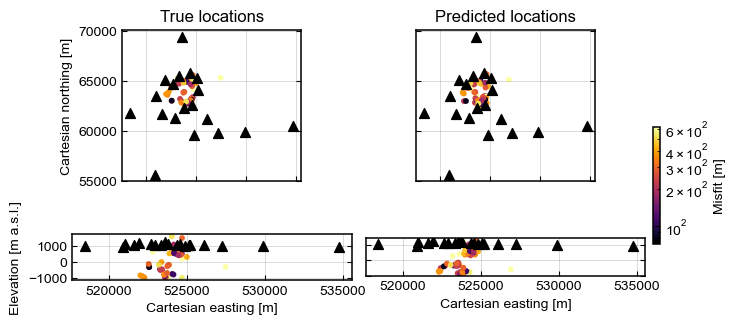

In [2]:
%run ../bin/tl-train config.yml